# Import libraries

In [1]:
import os
import getpass
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import csv
import umap
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from itertools import product
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
import random
import re

2024-04-28 15:14:51.298344: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 15:14:51.342595: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 15:14:51.342648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 15:14:51.344128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-28 15:14:51.352061: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 15:14:51.352764: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
def extract_email(arr):
    # Check if the input is a list or array
    if isinstance(arr, list) or isinstance(arr, np.ndarray):
        # Iterate through each element
        for element in arr:
            # Recursively call the function for nested lists or arrays
            email = extract_email(element)
            if email is not None:
                return email
    # If it's a string, check if it's an email address
    elif isinstance(arr, str):
        if re.match(r"[^@]+@[^@]+\.[^@]+", arr):
            return arr
    # Return None if no email address is found
    return None

In [3]:
question_significance = {
    "seating_question_1": "Salt or Paprika?",
    "seating_question_2": "Which starter pokemon would you choose?",
    "seating_question_3": "Which Hogward house are you?",
    "seating_question_4": "Ideal friday evening?",
    "seating_question_5": "What's your favorite drink?",
    "seating_question_6": "What is most likely to exist?",
    "seating_question_7": "What is the best aroma?",
    "seating_question_8": "What where we talking about?",
    "seating_question_9": "What is your favoured language?",
    "seating_question_10": "Who do you prefer?",
}

weigths = {
    "seating_question_1": 0.5,
    "seating_question_2": 1,
    "seating_question_3": 2,
    "seating_question_4": 2,
    "seating_question_5": 6,
    "seating_question_6": 6,
    "seating_question_7": 4,
    "seating_question_8": 3,
    "seating_question_9": 5,
    "seating_question_10": 1,
}

In [4]:
# Function to update values
def update_values(value_counts):
    def update(x):
        count = value_counts.get(x)
        if count:
            return f"{x}-{count}"
        else:
            return x
    return update

In [5]:

server = "ec2-54-72-196-9.eu-west-1.compute.amazonaws.com"
db = "d2fect8juldk3k"
user = "puybkltrealynp"
pswd = getpass.getpass(prompt="Enter password: ")
pswd_to_enter = "10aefdea5dcd6a4366ab1e0f46cbf91366144b7a3ad7252478db2c63357fec4e"
# Set the PGPASSWORD environment variable
os.environ['PGPASSWORD'] = pswd

# Execute the PostgreSQL command without specifying the password
os.system(f"psql -h {server} -U {user} -d {db} -c 'SELECT name, email, name, family_name, has_answered_form, answer_friday, answer_diner, answer_ceremony, answer_reception, plusones, seating_question_1, seating_question_2, seating_question_3, seating_question_4, seating_question_5, seating_question_6, seating_question_7, seating_question_8, seating_question_9, seating_question_10, seating_question_11, seating_question_12, seating_question_13, seating_question_14, seating_question_15 FROM users;' -o seatings.csv")


Enter password:  ········


0

# Load complete database

In [6]:
full_csv = pd.read_csv(f"seatings.csv", delimiter="|")
# Strip leading and trailing spaces from every element in the DataFrame
full_csv = full_csv.applymap(lambda x: x.strip() if isinstance(x, str) else x)
full_csv.columns = full_csv.columns.str.strip()
full_csv = full_csv.dropna()

/tmp/ipykernel_115305/2183413473.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  full_csv = full_csv.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [7]:
full_csv['email'] = full_csv['email'].str.lower()
full_csv['email'] = full_csv['email'].str.rstrip('.')
full_csv.to_csv(f"seating_cleaned.csv")

# People who answered but answered no (to double check)

In [8]:
check = full_csv[full_csv["has_answered_form"] == "yes"]
check = check[check["answer_diner"] == "no"]
check

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15
2,Alexis,alexis@adbproduction.com,Alexis,,yes,no,no,no,no,,...,06_nessie,07_chocolate,08_sex,09_france,10_love_math,,,,,
20,Laureline,laureline.maheo@yahoo.fr,Laureline,,yes,no,no,no,no,,...,,,,,,,,,,
22,Clarinette,cldursel@gmail.com,Clarinette,d'Ursel,yes,no,no,no,no,,...,,,,,,,,,,
32,Amelie,ami@dg.com,Amelie,,yes,no,no,no,no,Livia,...,06_god,07_pepper,08_spices,09_unitedkingdom,10_love_math,,,,,
33,Kyril,kyrilwittouck@gmail.com,Kyril,,yes,no,no,no,no,,...,,,,,,,,,,
35,Valentine,vdeselliers@hotmail.com,Valentine,,yes,no,no,no,no,kyrilwittouck@gmail.com,...,,,,,,,,,,
37,Pauline,paulinefaucon@hotmail.com,Pauline,,yes,no,no,no,no,,...,,,,,,,,,,
44,Isaure,isauredv@gmail.com,Isaure,,yes,no,no,no,no,,...,,,,,,,,,,
49,Olivier,odeguerre@free.fr,Olivier,,yes,no,no,no,no,,...,06_nessie,07_chocolate,08_icecream,09_france,10_love_liv,,,,,
52,Sarah,sarah.cresap.johnson@gmail.com,Sarah,Clemm,yes,no,no,no,no,,...,06_nessie,07_pistachio,08_icecream,09_unitedkingdom,10_love_liv,,,,,


# Double check the plusones to include them

In [9]:
where_plus_ones = full_csv[full_csv["plusones"].str.strip() != ""][['name','email','plusones']]
where_plus_ones['plusones'] = where_plus_ones['plusones'].str.rstrip('.')
temp = pd.DataFrame()
temp['email'] = list(where_plus_ones['plusones'])
temp['who_invites_them'] = list(where_plus_ones['email'])
# Assuming df1 and df2 are your DataFrames
merged_df = pd.merge(temp, full_csv[['email','name']],on='email', how='left')
merged_df
# Filter out rows with NaN values in the columns from df2
excluded_rows = merged_df[merged_df['name'].isnull()]
excluded_rows

,email,who_invites_them,name
9,Livia,ami@dg.com,NaN
22,Eugenia Caravaca Bayo,sebdeschrevel@hotmail.com,NaN
23,Louise Snoy,laurent.michiels@bain.com,NaN
28,Ania,philippe.labouchere@gmail.com,NaN
29,eleanor,zoomacc89@hotmail.com,NaN
37,Thomas,valeriedeguerre@gmail.com,NaN
38,Alexandre Quarles van Ufford,odeborchgrave@gmail.com,NaN
39,Laurence de Guerre,dominique.de.guerre@orange.fr,NaN
41,Isabelle,amarschall@ab-marschall.de,NaN
42,Alexander Wynaendts,cwynaendts@gmail.com,NaN


# Load additional information

In [10]:
additional = pd.read_csv(f"important_info.csv", delimiter=",",header=0)
additional['email'] = additional['email'].str.lower()
additional['email'] = additional['email'].str.rstrip('.')

In [11]:
merged_total = pd.merge(full_csv, additional[['email','Sex', 'friend_of','table','single']], on='email', how='inner')

duplicated_indices = [6]
while len(duplicated_indices) > 0:
    try:
        duplicated_indices = merged_total[merged_total.duplicated(subset=['email'], keep=False)].index
        index_to_drop = np.random.choice(duplicated_indices)
        merged_total = merged_total.drop(index_to_drop)
    except Exception as e:
        print(e)

'a' cannot be empty unless no samples are taken


# Filter out parents

In [12]:
youth = merged_total[merged_total["friend_of"]!="10_parents"]

In [13]:
youth[['name','family_name','email','has_answered_form','answer_friday','answer_ceremony','answer_reception','answer_diner']].to_csv(f"./final_youth_db.csv")

In [14]:
parents = merged_total[merged_total["friend_of"]=="10_parents"]
parents[['name','family_name','email','has_answered_form','answer_friday','answer_ceremony','answer_reception','answer_diner']].to_csv(f"./final_parents_db.csv")

# People from who we dont have information

In [15]:
merged_df = pd.merge(full_csv[['email','name']], additional[['email']], on='email', how='outer', suffixes=('_df1', '_df2'))
# Convert lists to sets
set1 = set(list(full_csv['email']))
set2 = set(list(additional['email']))

# Find elements not shared by both sets
elements_not_shared = set1.symmetric_difference(set2)
elements_not_shared

{'alexander.jordaan@gmail.com',
 'alexis@adbproduction.com',
 'bernardo.p.maciel@gmail.com',
 'cato.romero96@gmail.com',
 'chatelainpaul@hotmail.com',
 'i.libedinsky@vu.nl',
 'javi.stauffenberg@gmail.com',
 'jhroselaers@gmail.com',
 'josefinwerme@gmail.com',
 'karenlaupman@gmail.com',
 'mgx.vansteenbergh@hotmail.com',
 'nathan.y.bell@gmail.com',
 'plusone_phillipe',
 'sltettelaar@hotmail.com',
 'zoomacc89@hotmail.com'}

In [16]:
emails_list = list(elements_not_shared)
# Specify the CSV file path
csv_file_path = "not_shared.csv"

# Write list to CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['email'])  # Write header
    writer.writerows([[email] for email in emails_list])

# People who answered the form but didnt do the table seating game

In [17]:
answered_invitation_but_didnt_play = youth[youth['has_answered_form'] == 'yes']
answered_invitation_but_didnt_play = answered_invitation_but_didnt_play[answered_invitation_but_didnt_play["seating_question_1"].str.strip() == ""]
answered_invitation_but_didnt_play

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of,table,single
16,Laureline,laureline.maheo@yahoo.fr,Laureline,,yes,no,no,no,no,,...,,,,,,,female,10_mat,0,not single
18,Clarinette,cldursel@gmail.com,Clarinette,d'Ursel,yes,no,no,no,no,,...,,,,,,,female,10_mat,0,single
29,Kyril,kyrilwittouck@gmail.com,Kyril,,yes,no,no,no,no,,...,,,,,,,male,10_mat,0,not single
31,Valentine,vdeselliers@hotmail.com,Valentine,,yes,no,no,no,no,kyrilwittouck@gmail.com,...,,,,,,,female,10_mat,0,not single
33,Pauline,paulinefaucon@hotmail.com,Pauline,,yes,no,no,no,no,,...,,,,,,,female,10_mat,0,single
40,Isaure,isauredv@gmail.com,Isaure,,yes,no,no,no,no,,...,,,,,,,female,10_mat,0,not single
83,Laurent,laurent.michiels@bain.com,Laurent,Michiels,yes,no,no,no,no,Louise Snoy,...,,,,,,,male,10_mat,0,not single
96,Robert,vdlindenrj@gmail.com,Robert,van der Linden,yes,no,yes,yes,yes,,...,,,,,,,male,10_liv,0,not single
102,Phil,philippe.labouchere@gmail.com,Phil,,yes,no,no,no,no,Ania,...,,,,,,,male,10_liv,1,not single
141,Joyce,joycevn1@gmail.com,Joyce,Van Nieuwerburgh,yes,no,no,no,no,,...,,,,,,,female,10_mat,0,not single


# Randomize the answers of people who didnt do the game

In [18]:
temp = youth[youth["seating_question_1"].str.strip() != ""]

all_questions = ["seating_question_1","seating_question_2","seating_question_3","seating_question_4","seating_question_5","seating_question_6","seating_question_7","seating_question_8","seating_question_9","seating_question_10"]
randomized_answers = []

for quest in all_questions:
    answers = []
    for i in range(len(answered_invitation_but_didnt_play)):
        random_element = random.choice(list(temp[quest]))
        answers.append(random_element)
    answered_invitation_but_didnt_play[quest] = answers

In [19]:
youth = pd.concat([temp, answered_invitation_but_didnt_play], axis=0)

# All people who at least started the table seating game

In [20]:
only_answered = youth[youth["seating_question_1"].str.strip() != ""]

# Weird group who played but answered no for dinner

In [21]:
weird_group = only_answered[only_answered["answer_diner"] == "no"]
weird_group

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of,table,single
28,Amelie,ami@dg.com,Amelie,,yes,no,no,no,no,Livia,...,10_love_math,,,,,,female,10_mat,0,single
48,Sarah,sarah.cresap.johnson@gmail.com,Sarah,Clemm,yes,no,no,no,no,,...,10_love_liv,,,,,,female,10_liv,0,not single
67,Tony,adenicolay@gmail.com,Tony,de Nicolay,yes,no,no,no,no,,...,10_love_math,,,,,,male,10_mat,0,single
87,Aad,adriaanvanberckel2009@hotmail.com,Aad,,yes,no,no,no,no,,...,,,,,,,male,10_liv,0,single
157,Gaspar,gdursel@gmail.com,Gaspar,d'Ursel,yes,no,no,no,no,,...,10_love_liv,,,,,,male,10_mat,0,single
16,Laureline,laureline.maheo@yahoo.fr,Laureline,,yes,no,no,no,no,,...,10_love_math,,,,,,female,10_mat,0,not single
18,Clarinette,cldursel@gmail.com,Clarinette,d'Ursel,yes,no,no,no,no,,...,10_love_liv,,,,,,female,10_mat,0,single
29,Kyril,kyrilwittouck@gmail.com,Kyril,,yes,no,no,no,no,,...,10_love_math,,,,,,male,10_mat,0,not single
31,Valentine,vdeselliers@hotmail.com,Valentine,,yes,no,no,no,no,kyrilwittouck@gmail.com,...,10_love_liv,,,,,,female,10_mat,0,not single
33,Pauline,paulinefaucon@hotmail.com,Pauline,,yes,no,no,no,no,,...,10_love_liv,,,,,,female,10_mat,0,single


In [22]:
len(only_answered)

161

# Filtering out those who said no to the diner

In [23]:
only_answered = only_answered[only_answered["answer_diner"]!="no"]

# Double checking one last time plusones

In [24]:
where_plus_ones = only_answered[only_answered["plusones"].str.strip() != ""][['name','email','plusones']]
where_plus_ones['plusones'] = where_plus_ones['plusones'].str.rstrip('.')
temp = pd.DataFrame()
temp['email'] = list(where_plus_ones['plusones'])
temp['who_invites_them'] = list(where_plus_ones['email'])
# Assuming df1 and df2 are your DataFrames
merged_df = pd.merge(temp, only_answered[['email','name']],on='email', how='left')
merged_df
# Filter out rows with NaN values in the columns from df2
excluded_rows = merged_df[merged_df['name'].isnull()]
excluded_rows

,email,who_invites_them,name
2,philipvb@outlook.com,mpwesterwoudt@gmail.com,NaN
19,laureline.maheo@yahoo.fr,charko.doultremont@gmail.com,NaN
20,Eugenia Caravaca Bayo,sebdeschrevel@hotmail.com,NaN


# Only seating questions to encode

In [25]:
only_seating_colls = only_answered[["friend_of","table","single","seating_question_1","seating_question_2","seating_question_3","seating_question_4","seating_question_5","seating_question_6","seating_question_7","seating_question_8","seating_question_9","seating_question_10"]]
only_seating_colls = only_seating_colls.applymap(lambda x: str(x).split('_')[-1])
only_seating_colls.replace(r'^\s*$', "no answer", regex=True, inplace=True)

/tmp/ipykernel_115305/1893935590.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  only_seating_colls = only_seating_colls.applymap(lambda x: str(x).split('_')[-1])


In [26]:
mask = (only_seating_colls == "no answer").any(axis=1)
temp = only_answered[['name','email']]
temp = pd.concat([temp, only_seating_colls], axis = 1)
not_finished_answering = temp[mask]
not_finished_answering

,name,email,friend_of,table,single,seating_question_1,seating_question_2,seating_question_3,seating_question_4,seating_question_5,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10
159,Zarah & Duco,duco@duna.io,liv,0,not single,salt,bulbasaur,slitherin,clubbing,wine,aliens,chocolate,spices,no answer,liv


In [27]:
filtered_df = only_seating_colls[~mask]
needed_later = only_answered
needed_later = needed_later[~mask]

In [28]:
# Initialize OneHotEncoder
encoder = OneHotEncoder()
# Fit and transform the data
encoded_data = encoder.fit_transform(filtered_df)

In [29]:
one_hot_encoded = pd.DataFrame(encoded_data.toarray(), columns = encoder.get_feature_names_out())

# Weight the different questions differently

In [30]:
nr_features = {
    "friend_of": 2,
    "table": 4,
    "single":2,
    "seating_question_1": 2,
    "seating_question_2": 3,
    "seating_question_3": 4,
    "seating_question_4": 3,
    "seating_question_5": 6,
    "seating_question_6": 5,
    "seating_question_7": 4,
    "seating_question_8": 3,
    "seating_question_9": 4,
    "seating_question_10": 2,
}

question_significance = {
    "friend_of": "Who is inviting them?",
    "table": "which table",
    "single": "Relationship status?",
    "seating_question_1": "Salt or Paprika?",
    "seating_question_2": "Which starter pokemon would you choose?",
    "seating_question_3": "Which Hogward house are you?",
    "seating_question_4": "Ideal friday evening?",
    "seating_question_5": "What's your favorite drink?",
    "seating_question_6": "What is most likely to exist?",
    "seating_question_7": "What is the best aroma?",
    "seating_question_8": "What where we talking about?",
    "seating_question_9": "What is your favoured language?",
    "seating_question_10": "Who do you prefer?",
}


weigths = {
    "friend_of": 0,
    "table": 0.9,
    "single": 0.9,
    "seating_question_1": 0.4,
    "seating_question_2": 1.2,
    "seating_question_3": 0.9,
    "seating_question_4": 0.7,
    "seating_question_5": 0.6,
    "seating_question_6": 0.8,
    "seating_question_7": 0.5,
    "seating_question_8": 0.5,
    "seating_question_9": 0.5,
    "seating_question_10": 0.5,
}

In [31]:
scaler = StandardScaler()
scaler.fit(one_hot_encoded)
normalized_data = scaler.transform(one_hot_encoded)
one_hot_encoded = pd.DataFrame(normalized_data, columns=one_hot_encoded.columns)
temp = list(one_hot_encoded.columns)
modified_array = [word[:word.rindex('_')] for word in temp]
to_multi_1 = []
to_multi_2 = []
for word in modified_array:
    to_multi_1.append(weigths[word])
    to_multi_2.append(nr_features[word])
# Multiply each column with its corresponding float
for i, col in enumerate(one_hot_encoded.columns):
    one_hot_encoded[col] = one_hot_encoded[col] * to_multi_1[i]
    one_hot_encoded[col] = one_hot_encoded[col] * to_multi_2[i]
one_hot_encoded

,friend_of_liv,friend_of_mat,table_0,table_1,table_2,table_3,single_not single,single_single,seating_question_1_paprika,seating_question_1_salt,...,seating_question_7_vanilla,seating_question_8_icecream,seating_question_8_sex,seating_question_8_spices,seating_question_9_france,seating_question_9_germany,seating_question_9_netherlands,seating_question_9_unitedkingdom,seating_question_10_liv,seating_question_10_math
0,-0.0,0.0,-5.038950,5.637629,-0.523262,-0.606349,1.207477,-1.207477,0.762268,-0.762268,...,-0.450443,-1.510381,-0.814215,2.472930,2.157943,-0.544331,-0.776643,-1.428869,-1.224745,1.224745
1,-0.0,0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,-1.207477,0.762268,-0.762268,...,-0.450443,1.489691,-0.814215,-0.909852,-1.853617,-0.544331,-0.776643,2.799417,-1.224745,1.224745
2,0.0,-0.0,-5.038950,5.637629,-0.523262,-0.606349,1.207477,-1.207477,-0.839600,0.839600,...,-0.450443,1.489691,-0.814215,-0.909852,-1.853617,-0.544331,-0.776643,2.799417,0.816497,-0.816497
3,-0.0,0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,-1.207477,-0.839600,0.839600,...,-0.450443,-1.510381,-0.814215,2.472930,-1.853617,-0.544331,-0.776643,2.799417,-1.224745,1.224745
4,-0.0,0.0,-5.038950,5.637629,-0.523262,-0.606349,1.207477,-1.207477,0.762268,-0.762268,...,-0.450443,1.489691,-0.814215,-0.909852,2.157943,-0.544331,-0.776643,-1.428869,0.816497,-0.816497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,-0.0,0.0,-5.038950,-2.298839,24.767721,-0.606349,1.207477,-1.207477,0.762268,-0.762268,...,-0.450443,-1.510381,2.763397,-0.909852,2.157943,-0.544331,-0.776643,-1.428869,-1.224745,1.224745
141,-0.0,0.0,-5.038950,-2.298839,24.767721,-0.606349,-2.683282,2.683282,-0.839600,0.839600,...,-0.450443,1.489691,-0.814215,-0.909852,2.157943,-0.544331,-0.776643,-1.428869,-1.224745,1.224745
142,-0.0,0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,-1.207477,0.762268,-0.762268,...,-0.450443,1.489691,-0.814215,-0.909852,2.157943,-0.544331,-0.776643,-1.428869,-1.224745,1.224745
143,0.0,-0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,-1.207477,0.762268,-0.762268,...,-0.450443,-1.510381,2.763397,-0.909852,2.157943,-0.544331,-0.776643,-1.428869,0.816497,-0.816497


# Run PCA

In [32]:
nr_lower_dims = 2
lower_dims_labels = [f"dim{i}" for i in range(1, nr_lower_dims + 1)]

In [33]:
pca = PCA(n_components=nr_lower_dims)

# Fit the PCA model to your one-hot encoded DataFrame
pca.fit(one_hot_encoded)

# Transform the data to its principal components
pca_result = pca.transform(one_hot_encoded)

# Create a new DataFrame to store the principal components
pca_df = pd.DataFrame(data=pca_result, columns=lower_dims_labels)

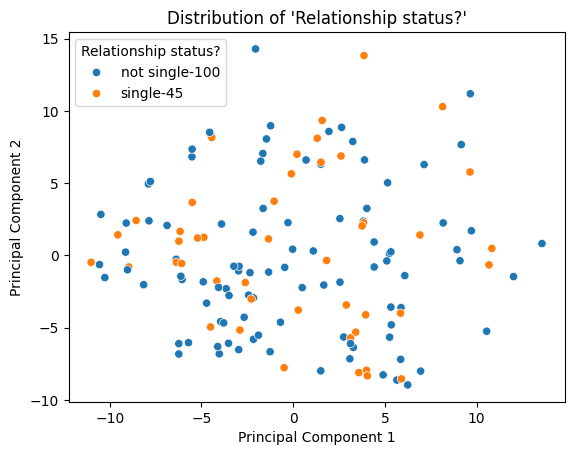

In [34]:
current_question = "single"
signify = question_significance[current_question]
pca_df[signify] = list(filtered_df[current_question])
value_counts = pca_df[signify].value_counts()
pca_df[signify] = pca_df[signify].apply(update_values(value_counts))
# Create a scatter plot using Seaborn
sns.scatterplot(x='dim1', y='dim2', data=pca_df, hue = signify)
plt.title(f"Distribution of '{signify}'")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

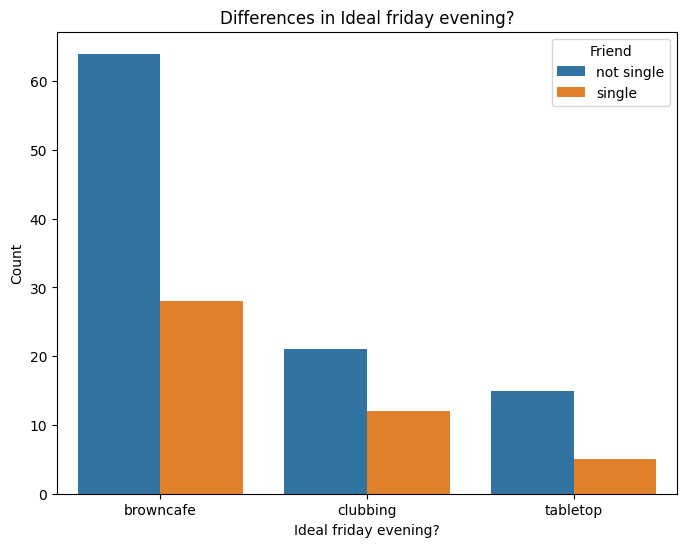

In [35]:
questionsy = 'seating_question_4'
# Assuming your DataFrame is named df
# Filter the DataFrame for friends 'mat' and 'liv'
temp = filtered_df[filtered_df['friend_of'].isin(['mat', 'liv'])]

# Create the countplot
plt.figure(figsize=(8, 6))
sns.countplot(data=temp, x=questionsy, hue='single')

# Set labels and title
plt.xlabel(f"{question_significance[questionsy]}")
plt.ylabel('Count')
plt.title(f"Differences in {question_significance[questionsy]}")

# Show plot
plt.legend(title='Friend')
plt.show()

# Run UMAP

In [36]:
# Run UMAP
reducer = umap.UMAP(n_components=nr_lower_dims)
embedding = reducer.fit_transform(one_hot_encoded)

In [37]:
# Create a new DataFrame to store the principal components
umap_df = pd.DataFrame(data=embedding, columns=lower_dims_labels)

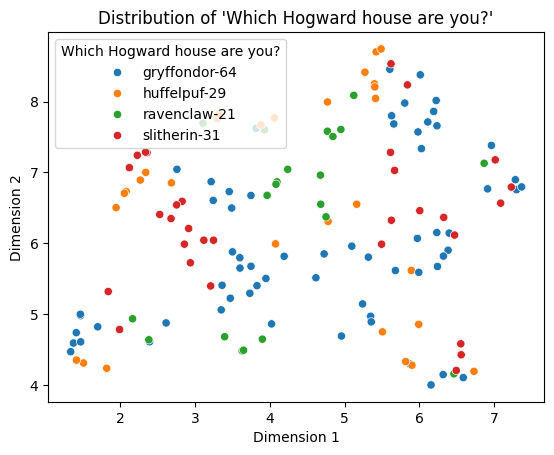

In [38]:
current_question = "seating_question_3"
signify = question_significance[current_question]
umap_df[signify] = list(filtered_df[current_question])
value_counts = umap_df[signify].value_counts()
umap_df[signify] = umap_df[signify].apply(update_values(value_counts))
# Create a scatter plot using Seaborn
sns.scatterplot(x='dim1', y='dim2', data=umap_df, hue = signify)
plt.title(f"Distribution of '{signify}'")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# Divide into Sith and Jedi

In [39]:
import pandas as pd
from sklearn.cluster import KMeans

# Assuming 'embedding' and 'lower_dims_labels' are defined elsewhere
umap_df = pd.DataFrame(data=embedding, columns=lower_dims_labels)
umap_df['Sex'] = list(needed_later['Sex'])

# Preprocess the data by encoding 'Sex' column to numerical values
umap_df['Sex'] = umap_df['Sex'].map({'male': 0, 'female': 1})

# Define the number of clusters (2 in this case)
n_clusters = 2

# Fit K-means clustering model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
umap_df['cluster'] = kmeans.fit_predict(umap_df[['dim1', 'dim2', 'Sex']])

# Calculate the number of males and females in each cluster
cluster_sex_counts = umap_df.groupby('cluster')['Sex'].value_counts().unstack(fill_value=0)

# Ensure approximately the same male/female ratio in each cluster
cluster_sex_counts = cluster_sex_counts.apply(lambda x: x / x.sum(), axis=1)
umap_df['cluster'] = umap_df['cluster'].map(cluster_sex_counts.idxmin(axis=1))

# Combine 'Sex' and 'cluster' to create 'groups' column
umap_df['force sensitives'] = umap_df.apply(lambda row: 'jedi man' if row['Sex'] == 0 and row['cluster'] == 1 else
                                             'jedi woman' if row['Sex'] == 1 and row['cluster'] == 1 else
                                             'sith man' if row['Sex'] == 0 and row['cluster'] == 0 else
                                             'sith woman' if row['Sex'] == 1 and row['cluster'] == 0 else '', axis=1)

# Calculate counts of each group
group_counts = umap_df['force sensitives'].value_counts()

/home/mat2m10/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [40]:
if group_counts['sith woman'] > group_counts['jedi woman']:
    to_transfer_fem = 'sith woman'
    oposit_female = 'jedi woman'
    total_to_transfer_fem = group_counts['sith woman']
    nr_to_transfer_fem = (group_counts['sith woman'] - group_counts['jedi woman'])//2
    
else:
    to_transfer_fem = 'jedi woman'
    oposit_female = 'sith woman'
    total_to_transfer_fem = group_counts['jedi woman']
    
    nr_to_transfer_fem = (group_counts['jedi woman'] - group_counts['sith woman'])//2

if group_counts['sith man'] > group_counts['jedi man']:
    total_to_transfer_male = group_counts['sith man']
    to_transfer_male = 'sith man'
    oposit_male = 'jedi man'
    nr_to_transfer_male = (group_counts['sith man'] - group_counts['jedi man'])//2
else:
    to_transfer_male = 'jedi man'
    oposit_male = 'sith man'
    total_to_transfer_male = group_counts['jedi man']
    nr_to_transfer_male = (group_counts['jedi man'] - group_counts['sith man'])//2

In [41]:
for i in range(nr_to_transfer_fem):
    df2 = umap_df[umap_df['force sensitives'] == f"{to_transfer_fem}"]
    opposit_m = umap_df[umap_df['force sensitives'] == f"{oposit_female}"]
    df1 = opposit_m.sample(n=1)
    
    nn = NearestNeighbors(n_neighbors=1, algorithm='auto')
    
    # Convert pandas DataFrames to numpy arrays
    df1_array = df1[lower_dims_labels].to_numpy()
    df2_array = df2[lower_dims_labels].to_numpy()
    df2_to_read = df2.to_numpy()
    
    # Flatten the arrays to 2D
    df1_flat = df1_array.reshape(len(df1_array), -1)
    df2_flat = df2_array.reshape(len(df2_array), -1)
    df2_to_read_flat = df2_to_read.reshape(len(df2_to_read), -1)
    
    nn.fit(df2_flat)
    distances, indices = nn.kneighbors(df1_flat)
    umap_df.loc[df2.head(indices[0][0]+1).tail(1).index, 'force sensitives'] = oposit_female
    group_counts = umap_df['force sensitives'].value_counts()


In [42]:
for i in range(nr_to_transfer_male):
    df2 = umap_df[umap_df['force sensitives'] == f"{to_transfer_male}"]
    opposit_m = umap_df[umap_df['force sensitives'] == f"{oposit_male}"]
    df1 = opposit_m.sample(n=1)
    
    nn = NearestNeighbors(n_neighbors=1, algorithm='auto')
    
    # Convert pandas DataFrames to numpy arrays
    df1_array = df1[lower_dims_labels].to_numpy()
    df2_array = df2[lower_dims_labels].to_numpy()
    df2_to_read = df2.to_numpy()
    
    # Flatten the arrays to 2D
    df1_flat = df1_array.reshape(len(df1_array), -1)
    df2_flat = df2_array.reshape(len(df2_array), -1)
    df2_to_read_flat = df2_to_read.reshape(len(df2_to_read), -1)
    
    nn.fit(df2_flat)
    distances, indices = nn.kneighbors(df1_flat)
    umap_df.loc[df2.head(indices[0][0]+1).tail(1).index, 'force sensitives'] = oposit_male

In [43]:
force_sensitive_counts = umap_df['force sensitives'].value_counts()
palette={f"sith man ({force_sensitive_counts['sith man']})":'#ab2118', 
         f"sith woman ({force_sensitive_counts['sith woman']})":'#e30b25', f"jedi man ({force_sensitive_counts['jedi man']})":'#0b2060', f"jedi woman ({force_sensitive_counts['jedi woman']})":'#3705ed'}
# Update values in 'force sensitives' column to include the count
umap_df['force sensitives'] = umap_df['force sensitives'] + " (" + umap_df['force sensitives'].map(force_sensitive_counts).astype(str) + ")"

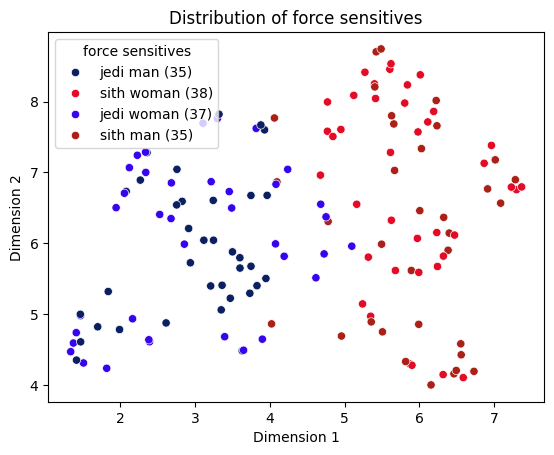

In [44]:
# Create a scatter plot using Seaborn
sns.scatterplot(x='dim1', y='dim2', data=umap_df, hue='force sensitives', palette=palette)
plt.title("Distribution of force sensitives")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [45]:
umap_df['force'] = umap_df['force sensitives'].str.split().str[0]
needed_later['force'] = list(umap_df['force'])

/tmp/ipykernel_115305/2471024797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  needed_later['force'] = list(umap_df['force'])


# Cluster pairs

In [46]:
nr_lower_dim = nr_lower_dims # based on how many dims you calculate the distance
lower_dims_labels = [f"dim{i}" for i in range(1, nr_lower_dims + 1)]

# First jedis

In [47]:
chosen_dim = umap_df.copy()

In [48]:
chosen_dim = chosen_dim[chosen_dim['force'] == 'jedi'][lower_dims_labels]

In [49]:
chosen_dim['gender'] = list(needed_later[needed_later['force'] == 'jedi']['Sex'])
chosen_dim['email'] = list(needed_later[needed_later['force'] == 'jedi']['email'])

In [50]:
gender_counts = chosen_dim['gender'].value_counts()
if gender_counts.female >= gender_counts.male:
    most_present = "female"
else:
    most_present = "male"

In [51]:
if most_present == 'female':
    least_present = 'male'
    starting_df = chosen_dim[chosen_dim['gender']=='male'][lower_dims_labels+['email']]
    overschot = chosen_dim[chosen_dim['gender']=='female'][lower_dims_labels+['email']]
else:
    least_present = 'female'
    overschot = chosen_dim[chosen_dim['gender']=='male'][lower_dims_labels+['email']]
    starting_df = chosen_dim[chosen_dim['gender']=='female'][lower_dims_labels+['email']]

In [52]:
extraction = one_hot_encoded.copy()
extraction['email'] = list(needed_later['email'])
extraction['name'] = list(needed_later['name'])
extraction['family_name'] = list(needed_later['family_name'])
columns = extraction.columns.tolist()
new_columns = columns[-3:] + columns[:-3]
extraction = extraction[new_columns]

matching_pairs_one_hot = []
matching_pairs_emails = []

nn = NearestNeighbors(n_neighbors=1, algorithm='auto')
starting_df = starting_df.sample(frac=1).reset_index(drop=True)

while len(starting_df) > 0:
    df1 = starting_df.head(1)
    df2 = overschot
    # Convert pandas DataFrames to numpy arrays
    df1_array = df1[lower_dims_labels].to_numpy()
    df2_array = df2[lower_dims_labels].to_numpy()
    df2_to_read = df2.to_numpy()

    # Flatten the arrays to 2D
    df1_flat = df1_array.reshape(len(df1_array), -1)
    df2_flat = df2_array.reshape(len(df2_array), -1)
    df2_to_read_flat = df2_to_read.reshape(len(df2_to_read), -1)

    nn.fit(df2_flat)
    distances, indices = nn.kneighbors(df1_flat)

    email_overschot = extract_email(df2_to_read_flat[indices])
    email_init = list(df1.email)[0]

    starting_df = starting_df[starting_df['email'] != email_init]
    overschot = overschot[overschot['email'] != email_overschot]

    couple = extraction[(extraction['email'] == email_overschot) | (extraction['email'] == email_init)]
    couple_additional_info = chosen_dim[(chosen_dim['email'] == email_overschot) | (chosen_dim['email'] == email_init)]
    merged_df = pd.merge(couple_additional_info, couple, on='email')
    columns = merged_df.columns.tolist()
    new_columns = merged_df.columns[3:6].tolist() + [col for col in columns if col not in merged_df.columns[3:6]]
    couple = merged_df[new_columns]

    matching_pairs_one_hot.append(couple)
    matching_pairs_emails.append([email_init,email_overschot])

In [53]:
matching_pairs_emails_df_jedi = pd.DataFrame(matching_pairs_emails, columns = [f"email {least_present}",f"email {most_present}"])

# Re-run for overschot jedi

In [54]:
if most_present == 'female':
    least_present = 'male'
    starting_df = overschot
    overschot = chosen_dim[chosen_dim['gender']=='male'][lower_dims_labels+['email']]
else:
    least_present = 'female'
    starting_df = overschot
    overschot = chosen_dim[chosen_dim['gender']=='female'][lower_dims_labels+['email']]

In [55]:
matching_pairs_overschot_one_hot = []
matching_pairs_overschot_emails = []
starting_df = starting_df.sample(frac=1).reset_index(drop=True)
while len(starting_df) > 0:
    df1 = starting_df.head(1)
    df2 = overschot
    # Convert pandas DataFrames to numpy arrays
    df1_array = df1[lower_dims_labels].to_numpy()
    df2_array = df2[lower_dims_labels].to_numpy()
    df2_to_read = df2.to_numpy()

    # Flatten the arrays to 2D
    df1_flat = df1_array.reshape(len(df1_array), -1)
    df2_flat = df2_array.reshape(len(df2_array), -1)
    df2_to_read_flat = df2_to_read.reshape(len(df2_to_read), -1)

    nn.fit(df2_flat)
    distances, indices = nn.kneighbors(df1_flat)

    email_overschot = extract_email(df2_to_read_flat[indices])
    email_init = list(df1.email)[0]

    starting_df = starting_df[starting_df['email'] != email_init]
    overschot = overschot[overschot['email'] != email_overschot]

    couple = extraction[(extraction['email'] == email_overschot) | (extraction['email'] == email_init)]
    couple_additional_info = chosen_dim[(chosen_dim['email'] == email_overschot) | (chosen_dim['email'] == email_init)]
    merged_df = pd.merge(couple_additional_info, couple, on='email')
    columns = merged_df.columns.tolist()
    new_columns = merged_df.columns[3:6].tolist() + [col for col in columns if col not in merged_df.columns[3:6]]
    couple = merged_df[new_columns]

    matching_pairs_overschot_one_hot.append(couple)
    matching_pairs_overschot_emails.append([email_init,email_overschot])

In [56]:
matching_pairs_overschot_emails_df_jedi = pd.DataFrame(matching_pairs_overschot_emails, columns = [f"email {most_present} overschot",f"email {least_present}"])

In [57]:
similarity_groups_jedi = pd.merge(matching_pairs_emails_df_jedi, matching_pairs_overschot_emails_df_jedi, on=f"email {least_present}", how="outer")
similarity_groups_jedi['gender'] = 'jedi'
similarity_groups_jedi

,email male,email female,email female overschot,gender
0,pietervanberckel01@gmail.com,isalinebaudry@hotmail.com,NaN,jedi
1,rafdegroot@gmail.com,e.haitsmamulier@gmail.com,NaN,jedi
2,johannes.schurmann@i-e.nl,jvanvolsem@gmail.com,NaN,jedi
3,n.wery@outlook.com,alice.athanassiadis@gmail.com,NaN,jedi
4,j.siegelmann@me.com,mariettebalder@gmail.com,NaN,jedi
5,tom.cassells14@gmail.com,poli.camilla@gmail.com,NaN,jedi
6,jeroenvandishoeck@hotmail.com,geekforgreek@gmail.com,NaN,jedi
7,gabriel.delaunoit@gmail.com,rendtz@gmail.com,kientzelceline@gmail.com,jedi
8,eberhard@redrink.co,devries.cee@gmail.com,NaN,jedi
9,marsanraphael@gmail.com,laurawaldersee@gmail.com,NaN,jedi


# Now Sith

In [58]:
chosen_dim = umap_df.copy()
chosen_dim = chosen_dim[chosen_dim['force'] == 'sith'][lower_dims_labels]
chosen_dim['gender'] = list(needed_later[needed_later['force'] == 'sith']['Sex'])
chosen_dim['email'] = list(needed_later[needed_later['force'] == 'sith']['email'])

In [59]:
gender_counts = chosen_dim['gender'].value_counts()
if gender_counts.female >= gender_counts.male:
    most_present = "female"
else:
    most_present = "male"

In [60]:
if most_present == 'female':
    least_present = 'male'
    starting_df = chosen_dim[chosen_dim['gender']=='male'][lower_dims_labels+['email']]
    overschot = chosen_dim[chosen_dim['gender']=='female'][lower_dims_labels+['email']]
else:
    least_present = 'female'
    overschot = chosen_dim[chosen_dim['gender']=='male'][lower_dims_labels+['email']]
    starting_df = chosen_dim[chosen_dim['gender']=='female'][lower_dims_labels+['email']]

In [61]:
extraction = one_hot_encoded.copy()
extraction['email'] = list(needed_later['email'])
extraction['name'] = list(needed_later['name'])
extraction['family_name'] = list(needed_later['family_name'])
columns = extraction.columns.tolist()
new_columns = columns[-3:] + columns[:-3]
extraction = extraction[new_columns]

matching_pairs_one_hot = []
matching_pairs_emails = []

nn = NearestNeighbors(n_neighbors=1, algorithm='auto')
starting_df = starting_df.sample(frac=1).reset_index(drop=True)

while len(starting_df) > 0:
    df1 = starting_df.head(1)
    df2 = overschot
    # Convert pandas DataFrames to numpy arrays
    df1_array = df1[lower_dims_labels].to_numpy()
    df2_array = df2[lower_dims_labels].to_numpy()
    df2_to_read = df2.to_numpy()

    # Flatten the arrays to 2D
    df1_flat = df1_array.reshape(len(df1_array), -1)
    df2_flat = df2_array.reshape(len(df2_array), -1)
    df2_to_read_flat = df2_to_read.reshape(len(df2_to_read), -1)

    nn.fit(df2_flat)
    distances, indices = nn.kneighbors(df1_flat)

    email_overschot = extract_email(df2_to_read_flat[indices])
    email_init = list(df1.email)[0]

    starting_df = starting_df[starting_df['email'] != email_init]
    overschot = overschot[overschot['email'] != email_overschot]

    couple = extraction[(extraction['email'] == email_overschot) | (extraction['email'] == email_init)]
    couple_additional_info = chosen_dim[(chosen_dim['email'] == email_overschot) | (chosen_dim['email'] == email_init)]
    merged_df = pd.merge(couple_additional_info, couple, on='email')
    columns = merged_df.columns.tolist()
    new_columns = merged_df.columns[3:6].tolist() + [col for col in columns if col not in merged_df.columns[3:6]]
    couple = merged_df[new_columns]

    matching_pairs_one_hot.append(couple)
    matching_pairs_emails.append([email_init,email_overschot])

In [62]:
matching_pairs_emails_df_sith = pd.DataFrame(matching_pairs_emails, columns = [f"email {least_present}",f"email {most_present}"])

# Re-run for overschot sith

In [63]:
if most_present == 'female':
    least_present = 'male'
    starting_df = overschot
    overschot = chosen_dim[chosen_dim['gender']=='male'][lower_dims_labels+['email']]
else:
    least_present = 'female'
    starting_df = overschot
    overschot = chosen_dim[chosen_dim['gender']=='female'][lower_dims_labels+['email']]

In [64]:
matching_pairs_overschot_one_hot = []
matching_pairs_overschot_emails = []
starting_df = starting_df.sample(frac=1).reset_index(drop=True)
while len(starting_df) > 0:
    df1 = starting_df.head(1)
    df2 = overschot
    # Convert pandas DataFrames to numpy arrays
    df1_array = df1[lower_dims_labels].to_numpy()
    df2_array = df2[lower_dims_labels].to_numpy()
    df2_to_read = df2.to_numpy()

    # Flatten the arrays to 2D
    df1_flat = df1_array.reshape(len(df1_array), -1)
    df2_flat = df2_array.reshape(len(df2_array), -1)
    df2_to_read_flat = df2_to_read.reshape(len(df2_to_read), -1)

    nn.fit(df2_flat)
    distances, indices = nn.kneighbors(df1_flat)

    email_overschot = extract_email(df2_to_read_flat[indices])
    email_init = list(df1.email)[0]

    starting_df = starting_df[starting_df['email'] != email_init]
    overschot = overschot[overschot['email'] != email_overschot]

    couple = extraction[(extraction['email'] == email_overschot) | (extraction['email'] == email_init)]
    couple_additional_info = chosen_dim[(chosen_dim['email'] == email_overschot) | (chosen_dim['email'] == email_init)]
    merged_df = pd.merge(couple_additional_info, couple, on='email')
    columns = merged_df.columns.tolist()
    new_columns = merged_df.columns[3:6].tolist() + [col for col in columns if col not in merged_df.columns[3:6]]
    couple = merged_df[new_columns]

    matching_pairs_overschot_one_hot.append(couple)
    matching_pairs_overschot_emails.append([email_init,email_overschot])

In [65]:
matching_pairs_overschot_emails_df_sith = pd.DataFrame(matching_pairs_overschot_emails, columns = [f"email {most_present} overschot",f"email {least_present}"])
matching_pairs_overschot_emails_df_sith

,email female overschot,email male
0,paulineranscelot@gmail.com,thom.hendriks@gmail.com
1,jiuliadansembourg@gmail.com,ldc@sreim.be
2,sophiewynaendts@gmail.com,harold.delacroix@gmail.com


In [66]:
similarity_groups_sith = pd.merge(matching_pairs_emails_df_sith, matching_pairs_overschot_emails_df_sith, on=f"email {least_present}", how="outer")
similarity_groups_sith['gender'] = 'sith'
similarity_groups_sith

,email male,email female,email female overschot,gender
0,amiel.hadrien@gmail.com,ysalinedonner@gmail.com,NaN,sith
1,geoffroydecanniere@gmail.com,ipn@vub.de,NaN,sith
2,nicolasgodart@hotmail.com,alinefadie@gmail.com,NaN,sith
3,thom.hendriks@gmail.com,avanvolsem@hotmail.com,paulineranscelot@gmail.com,sith
4,thomasdeguerre@gmail.com,vandenbulcke.cha@gmail.com,NaN,sith
5,arnaud.decleve0807@gmail.com,amelboes@hotmail.com,NaN,sith
6,bertichat@gmail.com,camilledansembourg@gmail.com,NaN,sith
7,maartenjr.esser@gmail.com,mvlvputbus@gmail.com,NaN,sith
8,stevenvriesendorp@hotmail.com,l.h.devries@outlook.com,NaN,sith
9,amvaneden@gmail.com,constancevanberckel@gmail.com,NaN,sith


In [67]:
similarity_groups = pd.concat([similarity_groups_jedi, similarity_groups_sith], ignore_index=True)
similarity_groups

,email male,email female,email female overschot,gender
0,pietervanberckel01@gmail.com,isalinebaudry@hotmail.com,NaN,jedi
1,rafdegroot@gmail.com,e.haitsmamulier@gmail.com,NaN,jedi
2,johannes.schurmann@i-e.nl,jvanvolsem@gmail.com,NaN,jedi
3,n.wery@outlook.com,alice.athanassiadis@gmail.com,NaN,jedi
4,j.siegelmann@me.com,mariettebalder@gmail.com,NaN,jedi
...,...,...,...,...
65,adelin.philippe@gmail.com,intratorc@gmail.com,NaN,sith
66,bignick@blasband.com,svanberckel@hotmail.com,NaN,sith
67,edzard.knyphausen@gmail.com,freedom-22@hotmail.co.uk,NaN,sith
68,harold.loop@gmail.com,ylmsiemer@gmail.com,NaN,sith


# Recompressing for anti-pairs

In [68]:
extraction

,email,name,family_name,friend_of_liv,friend_of_mat,table_0,table_1,table_2,table_3,single_not single,...,seating_question_7_vanilla,seating_question_8_icecream,seating_question_8_sex,seating_question_8_spices,seating_question_9_france,seating_question_9_germany,seating_question_9_netherlands,seating_question_9_unitedkingdom,seating_question_10_liv,seating_question_10_math
0,pietdel@gmail.com,Pierre,Delacroix,-0.0,0.0,-5.038950,5.637629,-0.523262,-0.606349,1.207477,...,-0.450443,-1.510381,-0.814215,2.472930,2.157943,-0.544331,-0.776643,-1.428869,-1.224745,1.224745
1,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,-0.0,0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,...,-0.450443,1.489691,-0.814215,-0.909852,-1.853617,-0.544331,-0.776643,2.799417,-1.224745,1.224745
2,erica.efst@gmail.com,Erica,Efstratoudakis,0.0,-0.0,-5.038950,5.637629,-0.523262,-0.606349,1.207477,...,-0.450443,1.489691,-0.814215,-0.909852,-1.853617,-0.544331,-0.776643,2.799417,0.816497,-0.816497
3,darrenmk1@gmail.com,Darren,Kripaitis,-0.0,0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,...,-0.450443,-1.510381,-0.814215,2.472930,-1.853617,-0.544331,-0.776643,2.799417,-1.224745,1.224745
4,ch.starckmann@gmail.com,Charles-Henri,Starckmann,-0.0,0.0,-5.038950,5.637629,-0.523262,-0.606349,1.207477,...,-0.450443,1.489691,-0.814215,-0.909852,2.157943,-0.544331,-0.776643,-1.428869,0.816497,-0.816497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,khosrowshahidara@gmail.com,Dara,Khosrowshahi,-0.0,0.0,-5.038950,-2.298839,24.767721,-0.606349,1.207477,...,-0.450443,-1.510381,2.763397,-0.909852,2.157943,-0.544331,-0.776643,-1.428869,-1.224745,1.224745
141,nikou.kh03@gmail.com,Nikou,,-0.0,0.0,-5.038950,-2.298839,24.767721,-0.606349,-2.683282,...,-0.450443,1.489691,-0.814215,-0.909852,2.157943,-0.544331,-0.776643,-1.428869,-1.224745,1.224745
142,alice.athanassiadis@gmail.com,Alicia,,-0.0,0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,...,-0.450443,1.489691,-0.814215,-0.909852,2.157943,-0.544331,-0.776643,-1.428869,-1.224745,1.224745
143,vdlindenrj@gmail.com,Robert,van der Linden,0.0,-0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,...,-0.450443,-1.510381,2.763397,-0.909852,2.157943,-0.544331,-0.776643,-1.428869,0.816497,-0.816497


In [69]:
col_male = [name + "_male" for name in extraction.columns[3:]]
col_female = [name + "_female" for name in extraction.columns[3:]]
combined_headers = col_male + col_female

In [70]:
combined_arrays = []
for index, row in similarity_groups.iterrows():
    # Access row data using row['column_name'] or row[column_index]
    exctract_male = extraction[extraction['email'] == row[f"email {least_present}"]]
    exctract_female = extraction[extraction['email'] == row[f"email {most_present}"]]
    exctract_male_values = exctract_male.iloc[0].values[3:]
    exctract_female_values = exctract_female.iloc[0].values[3:]
    combined_values = list(exctract_male_values) + list(exctract_female_values)
    combined_arrays.append(combined_values)

In [71]:
lovers = pd.DataFrame(combined_arrays, columns = combined_headers)
lovers

,friend_of_liv_male,friend_of_mat_male,table_0_male,table_1_male,table_2_male,table_3_male,single_not single_male,single_single_male,seating_question_1_paprika_male,seating_question_1_salt_male,...,seating_question_7_vanilla_female,seating_question_8_icecream_female,seating_question_8_sex_female,seating_question_8_spices_female,seating_question_9_france_female,seating_question_9_germany_female,seating_question_9_netherlands_female,seating_question_9_unitedkingdom_female,seating_question_10_liv_female,seating_question_10_math_female
0,0.0,-0.0,2.571964,-2.298839,-0.523262,-0.606349,-2.683282,2.683282,0.762268,-0.762268,...,-0.450443,-1.510381,2.763397,-0.909852,2.157943,-0.544331,-0.776643,-1.428869,-1.224745,1.224745
1,0.0,-0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,-1.207477,-0.839600,0.839600,...,-0.450443,-1.510381,2.763397,-0.909852,-1.853617,-0.544331,-0.776643,2.799417,0.816497,-0.816497
2,0.0,-0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,-1.207477,0.762268,-0.762268,...,-0.450443,1.489691,-0.814215,-0.909852,2.157943,-0.544331,-0.776643,-1.428869,-1.224745,1.224745
3,-0.0,0.0,-5.038950,5.637629,-0.523262,-0.606349,1.207477,-1.207477,0.762268,-0.762268,...,-0.450443,1.489691,-0.814215,-0.909852,2.157943,-0.544331,-0.776643,-1.428869,-1.224745,1.224745
4,0.0,-0.0,-5.038950,5.637629,-0.523262,-0.606349,-2.683282,2.683282,-0.839600,0.839600,...,-0.450443,-1.510381,-0.814215,2.472930,-1.853617,-0.544331,5.150370,-1.428869,0.816497,-0.816497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,-0.0,0.0,2.571964,-2.298839,-0.523262,-0.606349,-2.683282,2.683282,0.762268,-0.762268,...,-0.450443,1.489691,-0.814215,-0.909852,2.157943,-0.544331,-0.776643,-1.428869,0.816497,-0.816497
66,-0.0,0.0,-5.038950,-2.298839,-0.523262,21.373816,1.207477,-1.207477,-0.839600,0.839600,...,-0.450443,-1.510381,2.763397,-0.909852,-1.853617,-0.544331,-0.776643,2.799417,0.816497,-0.816497
67,0.0,-0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,-1.207477,0.762268,-0.762268,...,-0.450443,1.489691,-0.814215,-0.909852,-1.853617,-0.544331,-0.776643,2.799417,-1.224745,1.224745
68,-0.0,0.0,-5.038950,5.637629,-0.523262,-0.606349,1.207477,-1.207477,0.762268,-0.762268,...,-0.450443,1.489691,-0.814215,-0.909852,-1.853617,-0.544331,5.150370,-1.428869,0.816497,-0.816497


# ReRun PCA

In [72]:
nr_lower_dims = 15
lower_dims_labels = [f"dim{i}" for i in range(1, nr_lower_dims + 1)]
pca = PCA(n_components=nr_lower_dims)

# Fit the PCA model to your one-hot encoded DataFrame
pca.fit(lovers)

# Transform the data to its principal components
pca_result = pca.transform(lovers)

# Create a new DataFrame to store the principal components
pca_df = pd.DataFrame(data=pca_result, columns=lower_dims_labels)

# ReRun UMAP

In [73]:
# Run UMAP
reducer = umap.UMAP(n_components=nr_lower_dims)
embedding = reducer.fit_transform(lovers)
# Create a new DataFrame to store the principal components
umap_df = pd.DataFrame(data=embedding, columns=lower_dims_labels)

# Create Nemesis clusters

In [74]:
nr_lower_dim = nr_lower_dims # based on how many dims you calculate the distance
lower_dims_labels = [f"dim{i}" for i in range(1, nr_lower_dims + 1)]

In [75]:
#chosen_dim = umap_df[lower_dims_labels] # choose umap or PCA (or others)
chosen_dim = umap_df[lower_dims_labels] # choose umap or PCA (or others)

In [76]:
similarity_groups

,email male,email female,email female overschot,gender
0,pietervanberckel01@gmail.com,isalinebaudry@hotmail.com,NaN,jedi
1,rafdegroot@gmail.com,e.haitsmamulier@gmail.com,NaN,jedi
2,johannes.schurmann@i-e.nl,jvanvolsem@gmail.com,NaN,jedi
3,n.wery@outlook.com,alice.athanassiadis@gmail.com,NaN,jedi
4,j.siegelmann@me.com,mariettebalder@gmail.com,NaN,jedi
...,...,...,...,...
65,adelin.philippe@gmail.com,intratorc@gmail.com,NaN,sith
66,bignick@blasband.com,svanberckel@hotmail.com,NaN,sith
67,edzard.knyphausen@gmail.com,freedom-22@hotmail.co.uk,NaN,sith
68,harold.loop@gmail.com,ylmsiemer@gmail.com,NaN,sith


In [151]:
chosen_dim[f"email {least_present}"] = list(similarity_groups[f"email {least_present}"])
chosen_dim[f"email {most_present}"] = list(similarity_groups[f"email {most_present}"])
chosen_dim[f"email {most_present} overschot"] = list(similarity_groups[f"email {most_present} overschot"])
chosen_dim[f"gender"] = list(similarity_groups[f"gender"])

In [152]:
gender_counts = chosen_dim['gender'].value_counts()
if gender_counts.jedi >= gender_counts.sith:
    most_present_force = "jedi"
else:
    most_present_force = "sith"

In [153]:
if most_present_force == 'jedi':
    least_present_force = 'sith'
    starting_df = chosen_dim[chosen_dim['gender']=='sith']
    starting_df = starting_df[lower_dims_labels+[f"email {least_present}", f"email {most_present}", f"email {most_present} overschot"]]
    overschot = chosen_dim[chosen_dim['gender']=='jedi']
    overschot = overschot[lower_dims_labels+[f"email {least_present}", f"email {most_present}", f"email {most_present} overschot"]]
else:
    least_present_force = 'jedi'
    overschot = chosen_dim[chosen_dim['gender']=='sith']
    overschot = overschot[lower_dims_labels+[f"email {least_present}", f"email {most_present}", f"email {most_present} overschot"]]

    starting_df = chosen_dim[chosen_dim['gender']=='jedi']
    starting_df = starting_df[lower_dims_labels+[f"email {least_present}", f"email {most_present}", f"email {most_present} overschot"]]

In [155]:
nn = NearestNeighbors(n_neighbors=1, algorithm='auto')
starting_df = starting_df.sample(frac=1).reset_index(drop=True)
nemesises = []
while len(starting_df) > 0:
    df1 = starting_df.head(1)
    df2 = overschot
    
    email_init = list(df1[f"email {least_present}"])[0]
    
    # Convert pandas DataFrames to numpy arrays
    df1_array = df1[lower_dims_labels].to_numpy()
    df2_array = df2[lower_dims_labels].to_numpy()
    df2_to_read = df2.to_numpy()

    # Flatten the arrays to 2D
    df1_flat = df1_array.reshape(len(df1_array), -1)
    df2_flat = df2_array.reshape(len(df2_array), -1)
    df2_to_read_flat = df2_to_read.reshape(len(df2_to_read), -1)

    nn.fit(df2_flat)
    distances, indices = nn.kneighbors(df1_flat)
    


    good = [df1.iloc[0][f"email {least_present}"],
            df1.iloc[0][f"email {most_present}"],
            df1.iloc[0][f"email {most_present} overschot"]]
    
    data = starting_df[lower_dims_labels].values
    distances = euclidean_distances(data, [data[0]])
    index_max_distance = distances.argmax()
    bad = [df2.iloc[index_max_distance][f"email {least_present}"],
           df2.iloc[index_max_distance][f"email {most_present}"],
            df2.iloc[index_max_distance][f"email {most_present} overschot"]]

    starting_df = starting_df[starting_df[f"email {least_present}"] != df1.iloc[0][f"email {least_present}"]]
    overschot = overschot[overschot[f"email {least_present}"] != df2.iloc[index_max_distance][f"email {least_present}"]]
    nemesises.append(good + bad)

In [158]:
cols = [f"{least_present} good", f"{most_present} good", f"{most_present} overschot good", f"{least_present} bad", f"{most_present} bad", f"{most_present} overschot bad"]

In [159]:
nemesises = pd.DataFrame(data = nemesises, columns = cols)
nemesises

,male good,female good,female overschot good,male bad,female bad,female overschot bad
0,bignick@blasband.com,svanberckel@hotmail.com,NaN,rafdegroot@gmail.com,e.haitsmamulier@gmail.com,NaN
1,stevenvriesendorp@hotmail.com,l.h.devries@outlook.com,NaN,augustinvde@hotmail.com,erica.efst@gmail.com,NaN
2,henrydetraux@gmail.com,amelie.thibautdem@gmail.com,NaN,guillain-cornet@hotmail.com,xenia@smitsvanoyen.com,NaN
3,sammie.katt@gmail.com,alice.j.sommer@gmail.com,NaN,maxime@paternotte.com,ilse.m.schol@gmail.com,NaN
4,matthijsdekempenaer@gmail.com,annadansembourg@gmail.com,NaN,khosrowshahidara@gmail.com,bencibea@gmail.com,NaN
5,gj.oudewesselink@gmail.com,cathelijnevanderwouden@gmail.com,NaN,alexis.philippartdefoy@gmail.com,resitherwood@gmail.com,NaN
6,adefoestraets@gmail.com,camille.testard@protonmail.com,NaN,charko.doultremont@gmail.com,tuanabukemyildiz@gmail.com,NaN
7,fvanlitsenburg@gmail.com,marielouise.esser@gmail.com,NaN,maxim@smitsvanoyen.com,ines.haitsma@gmail.com,NaN
8,geoffroydecanniere@gmail.com,ipn@vub.de,NaN,marsanraphael@gmail.com,laurawaldersee@gmail.com,NaN
9,adelin.philippe@gmail.com,intratorc@gmail.com,NaN,jeroenvandishoeck@hotmail.com,geekforgreek@gmail.com,NaN


# People without pairs

In [68]:
starting_df

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,email male,email female,email female overschot


In [69]:
cols = [f"{least_present} good", f"{most_present} good", f"{most_present} overschot good", f"{least_present} bad", f"{most_present} bad", f"{most_present} overschot bad"]

In [70]:
nemesises = pd.DataFrame(data = nemesises, columns = cols)
nemesises

,male good,female good,female overschot good,male bad,female bad,female overschot bad
0,thom.hendriks@gmail.com,avanvolsem@hotmail.com,ohman.molly@gmail.com,alexis.philippartdefoy@gmail.com,ines.haitsma@gmail.com,NaN
1,h.p.wynaendts@gmail.com,svanberckel@hotmail.com,NaN,maxime@paternotte.com,leaverdoodt@gmail.com,NaN
2,charko.doultremont@gmail.com,tuanabukemyildiz@gmail.com,NaN,matthijsdekempenaer@gmail.com,theresaisabelkruse@gmail.com,paulineranscelot@gmail.com
3,harold.loop@gmail.com,carolinewvh@gmail.com,NaN,harold.delacroix@gmail.com,sophiewynaendts@gmail.com,annadansembourg@gmail.com
4,eberhard@redrink.co,a.k.greul@gmail.com,NaN,henrydetraux@gmail.com,amelboes@hotmail.com,NaN
5,j.siegelmann@me.com,intratorc@gmail.com,NaN,francoisboulange@gmail.com,adeguerre146@hotmail.com,NaN
6,jdursel@gmail.com,n.z.borren@gmail.com,NaN,vdlindenrj@gmail.com,hortensevincotte@gmail.com,NaN
7,thomasdeguerre@gmail.com,vandenbulcke.cha@gmail.com,NaN,matthieu.dehemptinne@gmail.com,liviadeguerre@gmail.com,NaN
8,augustinvde@hotmail.com,alinefadie@gmail.com,NaN,khosrowshahidara@gmail.com,jiuliadansembourg@gmail.com,NaN
9,francois.m.joris@gmail.com,mariettebalder@gmail.com,NaN,ch.starckmann@gmail.com,annesophievv@hotmail.com,NaN


# Make tables

In [102]:
combined_arrays = []
for index, row in nemesises.iterrows():
    exctract_male_good = extraction[extraction['email'] == row[f"{least_present} good"]]
    exctract_male_good_values = exctract_male_good.iloc[0].values[3:]
    exctract_female_good = extraction[extraction['email'] == row[f"{most_present} good"]]
    exctract_female_good_values = exctract_female_good.iloc[0].values[3:]

    exctract_male_bad = extraction[extraction['email'] == row[f"{least_present} bad"]]
    exctract_male_bad_values = exctract_male_bad.iloc[0].values[3:]
    exctract_female_bad = extraction[extraction['email'] == row[f"{most_present} bad"]]
    exctract_female_bad_values = exctract_female_bad.iloc[0].values[3:]

    combined_values = list(exctract_male_good_values) + list(exctract_female_good_values) + list(exctract_male_bad_values) + list(exctract_female_bad_values)
    combined_arrays.append(combined_values)

In [103]:
col_male_good = [name + "_male_good" for name in extraction.columns[3:]]
col_female_good = [name + "_female_good" for name in extraction.columns[3:]]
col_male_good_bad = [name + "_male_bad" for name in extraction.columns[3:]]
col_female_good_bad = [name + "_female_bad" for name in extraction.columns[3:]]
combined_headers = col_male_good + col_female_good + col_male_good_bad + col_female_good_bad

In [104]:
tables = pd.DataFrame(combined_arrays, columns = combined_headers)
tables

,friend_of_liv_male_good,friend_of_mat_male_good,table_0_male_good,table_1_male_good,table_2_male_good,table_3_male_good,single_not single_male_good,single_single_male_good,seating_question_1_paprika_male_good,seating_question_1_salt_male_good,...,seating_question_7_vanilla_female_bad,seating_question_8_icecream_female_bad,seating_question_8_sex_female_bad,seating_question_8_spices_female_bad,seating_question_9_france_female_bad,seating_question_9_germany_female_bad,seating_question_9_netherlands_female_bad,seating_question_9_unitedkingdom_female_bad,seating_question_10_liv_female_bad,seating_question_10_math_female_bad
0,-0.0,0.0,-5.012637,5.610195,-0.525114,-0.608511,1.213560,-1.213560,0.756724,-0.756724,...,-0.452084,1.479309,-0.801784,-0.914174,-1.865615,-0.546358,-0.779744,2.828427,-1.235442,1.235442
1,-0.0,0.0,2.585465,-2.310080,-0.525114,-0.608511,1.213560,-1.213560,0.756724,-0.756724,...,-0.452084,1.479309,-0.801784,-0.914174,2.144065,-0.546358,-0.779744,-1.414214,0.809427,-0.809427
2,-0.0,0.0,2.585465,-2.310080,-0.525114,-0.608511,1.213560,-1.213560,0.756724,-0.756724,...,-0.452084,-1.520980,-0.801784,2.461238,-1.865615,-0.546358,5.129892,-1.414214,0.809427,-0.809427
3,-0.0,0.0,-5.012637,5.610195,-0.525114,-0.608511,-2.669831,2.669831,-0.845751,0.845751,...,-0.452084,-1.520980,2.806243,-0.914174,-1.865615,-0.546358,5.129892,-1.414214,0.809427,-0.809427
4,-0.0,0.0,2.585465,-2.310080,-0.525114,-0.608511,1.213560,-1.213560,-0.845751,0.845751,...,-0.452084,1.479309,-0.801784,-0.914174,2.144065,-0.546358,-0.779744,-1.414214,-1.235442,1.235442
5,0.0,-0.0,2.585465,-2.310080,-0.525114,-0.608511,1.213560,-1.213560,0.756724,-0.756724,...,-0.452084,1.479309,-0.801784,-0.914174,2.144065,-0.546358,-0.779744,-1.414214,-1.235442,1.235442
6,-0.0,0.0,-5.012637,-2.310080,24.680357,-0.608511,1.213560,-1.213560,0.756724,-0.756724,...,-0.452084,1.479309,-0.801784,-0.914174,2.144065,-0.546358,-0.779744,-1.414214,0.809427,-0.809427
7,0.0,-0.0,2.585465,-2.310080,-0.525114,-0.608511,1.213560,-1.213560,0.756724,-0.756724,...,-0.452084,1.479309,-0.801784,-0.914174,-1.865615,-0.546358,-0.779744,2.828427,0.809427,-0.809427
8,0.0,-0.0,2.585465,-2.310080,-0.525114,-0.608511,-2.669831,2.669831,-0.845751,0.845751,...,-0.452084,-1.520980,2.806243,-0.914174,2.144065,-0.546358,-0.779744,-1.414214,0.809427,-0.809427
9,-0.0,0.0,-5.012637,5.610195,-0.525114,-0.608511,-2.669831,2.669831,0.756724,-0.756724,...,-0.452084,1.479309,-0.801784,-0.914174,-1.865615,7.321202,-0.779744,-1.414214,0.809427,-0.809427


In [108]:
table_names_and_sizes = {
    "goldstrike":38,
    "tequila":12,
    "jagermeister":12,
    "liquer43":14,
    "salmari":14,
    "limoncello":14,
    "cointreau":12,
    "peardrop":12,
    "curacao":12,
    "genepi":10,
    "absynth":9
}

nr_of_tables = len(table_names_and_sizes)
nr_of_tables

11

In [109]:
total = sum(table_names_and_sizes.values())
total

159

In [111]:
needed_later

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of,table,single
0,Pierre,pietdel@gmail.com,Pierre,Delacroix,yes,no,yes,no,yes,,...,10_love_math,,,,,,male,10_mat,1,not single
1,Caroline,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,yes,no,yes,no,yes,leonore.vehmeijer@gmail.com,...,10_love_math,,,,,,female,10_mat,0,not single
2,Erica,erica.efst@gmail.com,Erica,Efstratoudakis,yes,yes,yes,yes,yes,aamoratis@gmail.com,...,10_love_liv,,,,,,female,10_liv,1,not single
3,Darren,darrenmk1@gmail.com,Darren,Kripaitis,yes,no,yes,yes,yes,,...,10_love_math,,,,,,male,10_mat,0,not single
4,Charles-Henri,ch.starckmann@gmail.com,Charles-Henri,Starckmann,yes,no,yes,no,yes,,...,10_love_liv,,,,,,male,10_mat,1,not single
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Robert,vdlindenrj@gmail.com,Robert,van der Linden,yes,no,yes,yes,yes,,...,10_love_liv,,,,,,male,10_liv,0,not single
101,Xenia,popowskixenia@gmail.com,Xenia,,yes,no,yes,yes,yes,,...,10_love_math,,,,,,female,10_liv,0,not single
160,Zarah & Duco,duco@duna.io,Zarah & Duco,van Lanschot - Abeln,yes,no,yes,yes,yes,,...,10_love_math,,,,,,male,10_liv,0,not single
200,BigNickkk,bignick@blasband.com,BigNickkk,Blasband,yes,no,yes,no,no,,...,10_love_math,,,,,,male,10_mat,3,not single


In [113]:
for element in np.sort(list(needed_later['email'])):
    print(element)

a.k.greul@gmail.com
aamoratis@gmail.com
adefoestraets@gmail.com
adeguerre146@hotmail.com
adelin.philippe@gmail.com
alexander.schwennicke@gmail.com
alexdehemptinne90@gmail.com
alexis.latinis@hotmail.com
alexis.philippartdefoy@gmail.com
alexr89@hotmail.fr
alexsvo@me.com
ali@digitalpark.be
alice.athanassiadis@gmail.com
alice.j.sommer@gmail.com
alinefadie@gmail.com
amelboes@hotmail.com
amelie.thibautdem@gmail.com
amiel.hadrien@gmail.com
amvaneden@gmail.com
annadansembourg@gmail.com
annesophievv@hotmail.com
arnaud.decleve0807@gmail.com
augustinvde@hotmail.com
avanvolsem@hotmail.com
bencibea@gmail.com
bergmansmartin2@hotmail.com
bertichat@gmail.com
bignick@blasband.com
c.carak@gmail.com
camille.testard@protonmail.com
camilledansembourg@gmail.com
carolinewvh@gmail.com
catalina.de.schrevel@hotmail.com
cathelijnevanderwouden@gmail.com
celestinedec@gmail.com
ch.starckmann@gmail.com
charko.doultremont@gmail.com
christiaan.waller@live.nl
clausscamille@hotmail.com
constancevanberckel@gmail.com
cvdb

In [114]:
len(np.sort(list(needed_later['email'])))

144

In [87]:
youth[youth['seating_question_8'] == "08_sex"]

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of,table,single
14,Philibert,deloozphil@gmail.com,Philibert,De looz,yes,no,yes,yes,yes,,...,10_love_math,,,,,,male,10_mat,1,single
20,Matthieu,matthieu.dehemptinne@gmail.com,Matthieu,de Hemptinne,yes,yes,yes,no,yes,liviadeguerre@gmail.com,...,10_love_liv,,,,,,male,10_mat,1,not single
27,Eugenie,e.haitsmamulier@gmail.com,Eugenie,Mulier,yes,no,yes,yes,yes,,...,10_love_liv,,,,,,female,10_liv,0,single
31,Amelie,ami@dg.com,Amelie,,yes,no,no,no,no,Livia,...,10_love_math,,,,,,female,10_mat,0,single
41,Alexis,alexis.philippartdefoy@gmail.com,Alexis,Philippart de Foy,yes,no,yes,no,yes,,...,10_love_math,,,,,,male,10_mat,0,not single
46,Arny,adefoestraets@gmail.com,Arny,de Foestraets,yes,no,yes,no,yes,,...,10_love_liv,,,,,,male,10_mat,0,not single
47,Léopold,leopold.gerard@gmail.com,Léopold,Gérard,yes,no,yes,no,yes,c.carak@gmail.com,...,10_love_liv,,,,,,male,10_mat,1,not single
51,Alexander,alexsvo@me.com,Alexander,Smits van Oyen,yes,no,yes,yes,yes,popowskixenia@gmail.com,...,10_love_liv,,,,,,male,10_liv,0,not single
53,Isa,isalinebaudry@hotmail.com,Isa,Baudry,yes,no,yes,yes,yes,,...,10_love_math,,,,,,female,10_mat,0,not single
56,Baguerra,francois.m.joris@gmail.com,Baguerra,Joris,yes,no,yes,no,yes,,...,10_love_liv,,,,,,male,10_mat,1,not single


In [225]:
# Define the cluster sizes
cluster_sizes = [12, 15, 32, 6, 21]

# Initialize KMeans with the desired number of clusters
kmeans = KMeans(n_clusters=len(cluster_sizes))

# Fit KMeans to the UMAP-transformed data
clusters = kmeans.fit_predict(embedding)

# Assign each data point to a cluster
cluster_assignments = []
start = 0
for size in cluster_sizes:
    end = start + size
    cluster_assignments.append(clusters[start:end])
    start = end


NameError: name 'embedding' is not defined

In [ ]:
# Extract cluster labels
cluster_labels = kmeans.labels_
cluster_labels

In [ ]:
umap_df['tabels'] = cluster_labels

In [ ]:
sns.scatterplot(x='dim1', y='dim2', data=umap_df, hue = 'tabels',palette = 'viridis')
plt.title(f"Distribution of '{signify}'")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Groups of males and females

In [ ]:
umap_df = umap_df[['dim1','dim2','tabels']]
umap_df['gender'] = list(needed_later['Sex'])
umap_df['email'] = list(needed_later['email'])

In [ ]:
# Assuming umap_df is your DataFrame with columns 'dim1', 'dim2', and 'gender'
male_df = umap_df[umap_df['gender'] == 'male']
female_df = umap_df[umap_df['gender'] == 'female']

# Compute pairwise distances between male and female samples
distances = cdist(male_df[['dim1', 'dim2']], female_df[['dim1', 'dim2']])

# Find the closest male-female pairs
min_indices = distances.argmin(axis=1)
closest_pairs = [(male_df.iloc[i], female_df.iloc[j]) for i, j in enumerate(min_indices)]

# Create a DataFrame with the closest pairs
closest_pairs_df = pd.DataFrame(closest_pairs, columns=['Male', 'Female'])


In [ ]:
pair = closest_pairs_df.iloc[0]
male = pair['Male']
female = pair['Female']
match = pd.concat([pd.DataFrame(data=male),pd.DataFrame(data=female)],axis=1)
first_db = needed_later[['email','name','family_name']]
first_merge = pd.merge(first_db, match.T[['dim1','dim2','email']], on='email', how='inner')
values_array = [value for value in question_significance.values()]
third_db = needed_later[["friend_of","seating_question_1","seating_question_2","seating_question_3","seating_question_4","seating_question_5","seating_question_6","seating_question_7","seating_question_8","seating_question_9","seating_question_10"]]
# Create a dictionary mapping old column names to new column names
column_mapping = dict(zip(third_db.columns, values_array))

# Rename columns using the dictionary
third_db.rename(columns=column_mapping, inplace=True)
third_db = third_db.applymap(lambda x: str(x).split('_')[-1])
third_db.replace(r'^\s*$', "no answer", regex=True, inplace=True)
third_db['email'] = list(needed_later['email'])
last_merge = pd.merge(first_merge, third_db, on='email', how='inner')
last_merge